In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from glob import glob
import cv2

In [2]:
training_paths = glob('dataset\\dataset\\training_data\\images\\*.png')
len(training_paths)

149

In [3]:
images = []
for path in training_paths:
    new_thresh = Image.open(path)
    new_thresh = np.array(new_thresh)
    images.append(new_thresh.shape)

# Read Image

In [4]:
training_paths = glob('dataset\\dataset\\training_data\\images\\*.png')

In [5]:
def convert_to_binary(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    return thresh

In [6]:
def filter_small_blobs(thresh, min_size=100):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)
    new_thresh = thresh.copy()
    for i in range(1, num_labels):
        blob = labels == i
        if blob.sum() <= min_size:
            new_thresh[blob] = 0

    return new_thresh

In [7]:
def convert_to_components(thresh, kernel_size=5, iterations=2):

    # dilate the image to connect the components
    kernel = np.ones((kernel_size, kernel_size),np.uint8)
    dilated_image = cv2.dilate(thresh, kernel, iterations = iterations)

    # find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated_image, connectivity=4)

    # combine labels with thresh img. Ink is written in it's blob number
    # Make labels 0 where thresh is 0
    labels[thresh == 0] = 0

    return labels, num_labels, stats, dilated_image

In [46]:
def move_objects(labels, max_dx=40, max_dy=40):
    transformed_img = np.zeros_like(labels)
    random_order_labels = np.unique(labels)[1:]
    np.random.shuffle(random_order_labels)
    new_labels = np.zeros_like(labels)
    for i in random_order_labels:
        blob = labels == i
        blob_idx = np.argwhere(blob)

        num_tries = 0
        while True:
            if num_tries > 100:
                print('too many tries')
                transformed_img[blob_idx[:,0], blob_idx[:,1]] = 1
                new_labels[blob_idx[:,0], blob_idx[:,1]] = i
                break

            if max_dx == 0 and max_dy == 0:
                dx = 0
                dy = 0
            else:
                dx = np.random.randint(2, max_dx) * np.random.choice([-1, 1])
                dy = np.random.randint(2, max_dy) * np.random.choice([-1, 1])

            new_blob_idx = blob_idx + np.array([dy, dx])
            # if all new blob idx are in bounds
            if (new_blob_idx[:,0] >= 0).all() and (new_blob_idx[:,0] < transformed_img.shape[0]).all() and (new_blob_idx[:,1] >= 0).all() and (new_blob_idx[:,1] < transformed_img.shape[1]).all():
                if transformed_img[new_blob_idx[:,0], new_blob_idx[:,1]].sum() == 0:
                    transformed_img[new_blob_idx[:,0], new_blob_idx[:,1]] = 1
                    new_labels[new_blob_idx[:,0], new_blob_idx[:,1]] = i
                    break
            num_tries += 1

    return transformed_img, new_labels

In [9]:
def make_changes(labels, additions_in_left = 4, additions_in_right = 4):
    # extract components to make diff images
    count_changes = additions_in_left + additions_in_right
    diff_components = np.random.permutation(np.unique(labels))[1:count_changes+1] # includes 0
    left_components = diff_components[:additions_in_left]
    right_components = diff_components[additions_in_left:]

    # base is labels without diff components
    base = labels.copy()
    for i in diff_components:
        base[labels == i] = 0

    # make left and right images
    left = base.copy()
    for i in left_components:
        left[labels == i] = i

    right = base.copy()
    for i in right_components:
        right[labels == i] = i

    return left, right, left_components, right_components


In [43]:
def get_changes(labels, components):
    # get changes
    changes = np.zeros_like(labels)
    for i in components:
        if i == 0:
            continue
        changes[labels == i] = 1

    return changes

In [37]:
def generate_data(path, min_size=5, kernel_size=6, dilate_iterations=2, max_dx=40, max_dy=40, additions_in_left = 4, additions_in_right = 4):
    img = cv2.imread(path)

    thresh = convert_to_binary(img)

    thresh = filter_small_blobs(thresh, min_size=min_size)

    labels, num_labels, stats, dilated_image = convert_to_components(thresh, kernel_size=kernel_size, iterations=dilate_iterations)

    if len(np.unique(labels)) < 10:
        print('too few components')

    additions_in_left = np.random.randint(2, additions_in_left+1)
    additions_in_right = np.random.randint(2, additions_in_right+1)
    left, right, left_components, right_components = make_changes(labels, additions_in_left = additions_in_left, additions_in_right = additions_in_right)

    left_transformed_img, left_new_labels = move_objects(left, max_dx=max_dx, max_dy=max_dy)
    right_transformed_img, right_new_labels = move_objects(right, max_dx=max_dx, max_dy=max_dy)

    left_changes = get_changes(left_new_labels, left_components)
    right_changes = get_changes(right_new_labels, right_components)

    return left_transformed_img*255, right_transformed_img*255, left_changes*255, right_changes*255


In [12]:
def show_data(left_transformed_img, right_transformed_img, left_changes, right_changes):
    left_transformed_img = cv2.bitwise_not(left_transformed_img)
    right_transformed_img = cv2.bitwise_not(right_transformed_img)
    left_changes = cv2.bitwise_not(left_changes)
    right_changes = cv2.bitwise_not(right_changes)
    # show img and transformed img side by side
    fig, ax = plt.subplots(2,2, figsize=(20,20))
    ax[0,0].imshow(left_transformed_img, cmap='gray')
    ax[0,1].imshow(right_transformed_img, cmap='gray')
    ax[0,0].set_title('left transformed img')
    ax[0,1].set_title('right transformed img')
    ax[1,0].imshow(left_changes, cmap='gray')
    ax[1,1].imshow(right_changes, cmap='gray')
    ax[1,0].set_title('left changes')
    ax[1,1].set_title('right changes')
    # remove ticks
    for a in ax.flatten():
        a.set_xticks([])
        a.set_yticks([])
    plt.show()

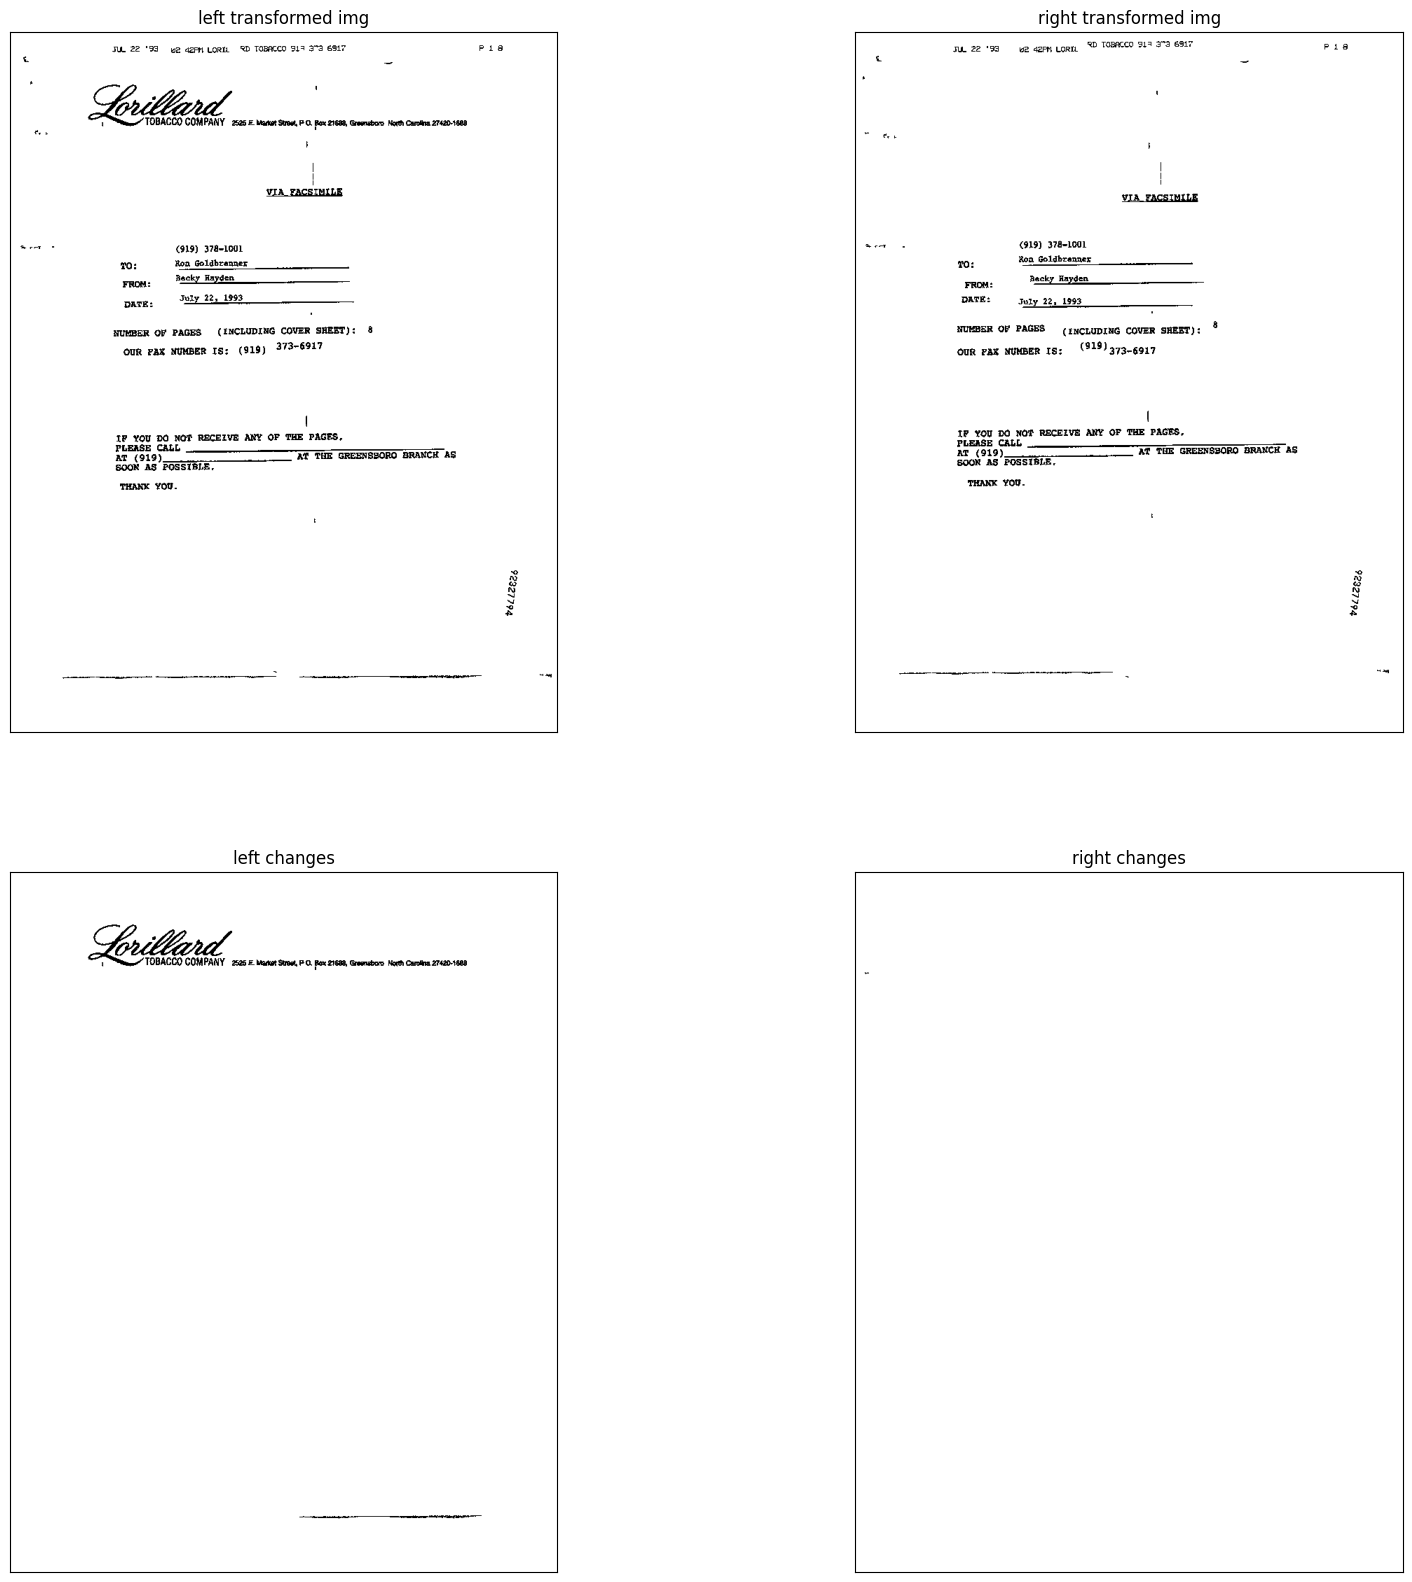

In [13]:
path = training_paths[45]
left_transformed_img, right_transformed_img, left_changes, right_changes = generate_data(path, min_size=5, kernel_size=6, dilate_iterations=2, max_dx=10, max_dy=5, additions_in_left = 5, additions_in_right = 5)

show_data(left_transformed_img, right_transformed_img, left_changes, right_changes)

In [14]:
assert ((left_transformed_img & left_changes) == left_changes).all()
assert ((right_transformed_img & right_changes) == right_changes).all()

# Generate and save data

In [15]:
import datetime as dt
from tqdm import tqdm

In [47]:
n_samples = 1000
min_size = 5
kernel_size = 4
dilate_iterations = 2
max_dx = 0
max_dy = 0
additions_in_left = 7
additions_in_right = 7

training_paths = glob('dataset\\dataset\\training_data\\images\\*.png')
np.random.shuffle(training_paths)

data_path = 'generated_data\\'
data_path = 'D:\\DocDiffGeneratedData\\'

datasets = glob(data_path + '*\\')


ids = [int(os.path.basename(dataset[:-1])) for dataset in datasets if os.path.isdir(dataset)]
ids = [0] if not ids else ids
new_id = max(ids) + 1

dataset_path =  data_path + f'{new_id}\\'
os.mkdir(dataset_path)

# save params
params = {'n_samples': n_samples,
            'min_size': min_size,
            'kernel_size': kernel_size,
            'dilate_iterations': dilate_iterations,
            'max_dx': max_dx,
            'max_dy': max_dy,
            'additions_in_left': additions_in_left,
            'additions_in_right': additions_in_right}
params = pd.DataFrame(params, index=[0])
params.to_csv(dataset_path + 'params.csv', index=False)

for i in tqdm(range(n_samples)):
    path = training_paths[i%len(training_paths)]
    left_transformed_img, right_transformed_img, left_changes, right_changes = generate_data(path, min_size=min_size, kernel_size=kernel_size, dilate_iterations=dilate_iterations, max_dx=max_dx, max_dy=max_dy, additions_in_left = additions_in_left, additions_in_right = additions_in_right)

    # get hashed datetime as id
    now = dt.datetime.now()
    id = hash(now)

    # save images
    cv2.imwrite(dataset_path + f"{os.path.basename(path).split('.')[0]}_left_transformed_img_{id}.png", left_transformed_img)

    cv2.imwrite(dataset_path + f"{os.path.basename(path).split('.')[0]}_right_transformed_img_{id}.png", right_transformed_img)

    cv2.imwrite(dataset_path + f"{os.path.basename(path).split('.')[0]}_left_changes_{id}.png", left_changes)

    cv2.imwrite(dataset_path + f"{os.path.basename(path).split('.')[0]}_right_changes_{id}.png", right_changes)


 46%|████▋     | 465/1000 [14:43<13:52,  1.56s/it]  

# Read Generated data

-3563738156303172891
-5821571515104867548
8138254205962694268
8243751016159381709


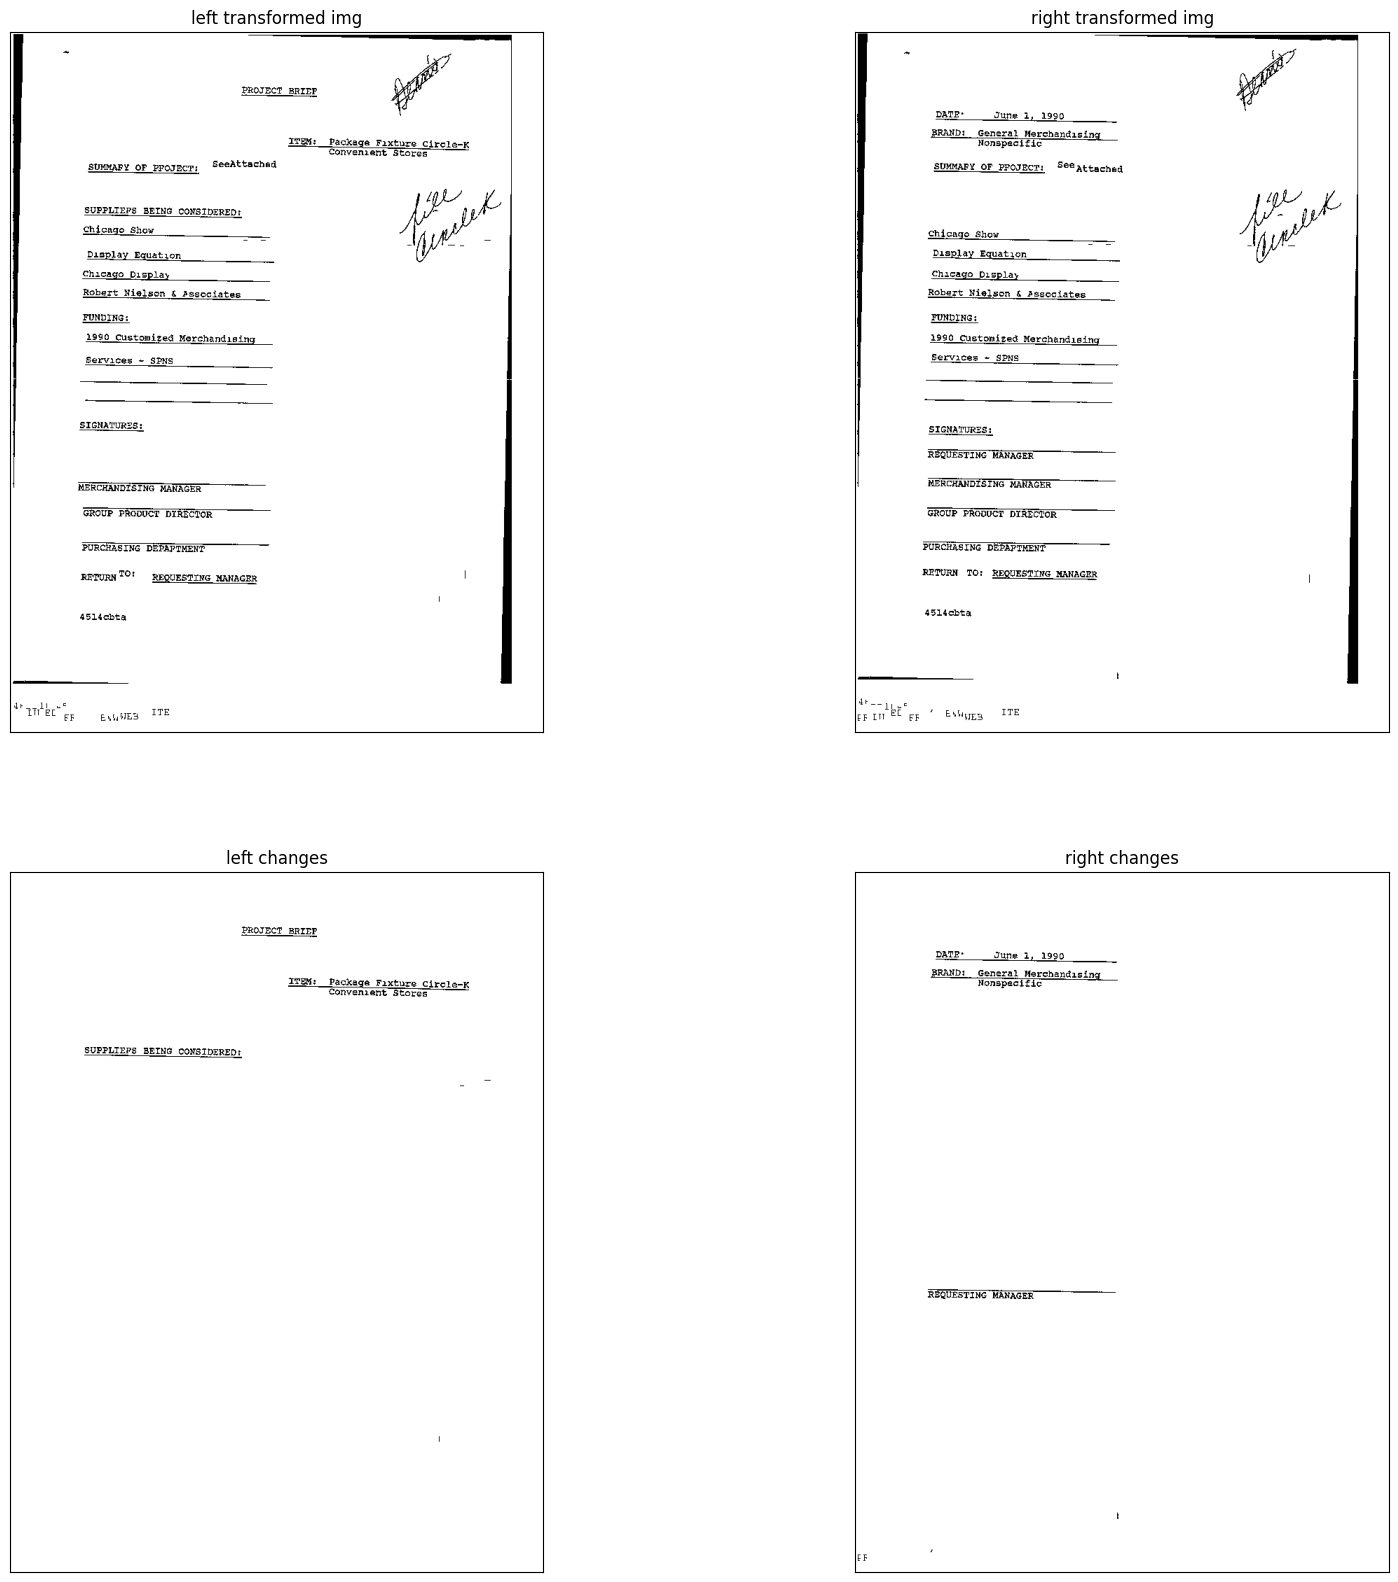

In [41]:
dataset = '2'
data_path = 'generated_data\\'
data_path = 'D:\\DocDiffGeneratedData\\'
images = glob(data_path +  dataset + '\\*.png')

def parse_filename(path):
    filename = os.path.basename(path)
    filename = filename.split('.')[0].split('_')
    pic_num = filename[0]
    id = filename[-1]
    type_ = '_'.join(filename[1:-1])
    return pic_num, type_, id


ids = []
for image in images:
    pic_num, type_, id = parse_filename(image)
    ids.append(id)
ids = np.array(ids)
unique_ids = np.unique(ids)
print('\n'.join(unique_ids))
id = input('enter id: ')

images = glob(data_path +  dataset + f'\\*_{id}.png')

for image in images:
    pic_num, type_, id = parse_filename(image)
    img = cv2.imread(image)
    if type_ == 'left_transformed_img':
        left_transformed_img = img
    elif type_ == 'right_transformed_img':
        right_transformed_img = img
    elif type_ == 'left_changes':
        left_changes = img
    elif type_ == 'right_changes':
        right_changes = img

show_data(left_transformed_img, right_transformed_img, left_changes, right_changes)